# FashionMNIST dataset

## Pre Step: Adding Necessary Tools

In [ ]:
#for numerical
import numpy as np

#for dataframe
import pandas as pd

#pytorch for building deep learning models
import torch
import torch.nn as nn #neural network
import torch.optim as optim #optimization algorithms
from torch.utils.data import DataLoader #load data

#used to search for files that match a specific file pattern or name
import glob

#Python Image Library
from PIL import Image

#in order to plot figures
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#download zip file
!wget https://raw.githubusercontent.com/Abtinmy/CS-SBU-NeuralNetwork/main/assignments/Assignment%202/Dataset.zip

--2023-06-18 14:08:50--  https://raw.githubusercontent.com/Abtinmy/CS-SBU-NeuralNetwork/main/assignments/Assignment%202/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66764119 (64M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  63.67M   301MB/s    in 0.2s    

2023-06-18 14:09:03 (301 MB/s) - ‘Dataset.zip’ saved [66764119/66764119]



In [ ]:
#Creating a path to save images
!mkdir dataset

In [ ]:
#Unzipping dataset
!unzip /content/Dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/mnist_middle_columns/26957.jpg  
  inflating: /content/dataset/mnist_middle_columns/83.csv  
  inflating: /content/dataset/mnist_middle_columns/4921.csv  
  inflating: /content/dataset/mnist_middle_columns/34436.jpg  
  inflating: /content/dataset/mnist_middle_columns/28228.csv  
  inflating: /content/dataset/mnist_middle_columns/11910.csv  
  inflating: /content/dataset/mnist_middle_columns/24492.jpg  
  inflating: /content/dataset/mnist_middle_columns/32617.jpg  
  inflating: /content/dataset/mnist_middle_columns/57638.csv  
  inflating: /content/dataset/mnist_middle_columns/37617.csv  
  inflating: /content/dataset/mnist_middle_columns/35601.jpg  
  inflating: /content/dataset/mnist_middle_columns/42223.csv  
  inflating: /content/dataset/mnist_middle_columns/24519.csv  
  inflating: /content/dataset/mnist_middle_columns/40571.csv  
  inflating: /content/dataset/mnist_middle_columns/54769.jpg  
  inflat

In [ ]:
#getting list path of images path with jpg format
list_path = glob.glob('/content/dataset/mnist_middle_columns/*.jpg')

##Task 1: Split the data into train and test sets.


In [ ]:
test_ratio = 0.2
test_size = int(test_ratio * len(list_path))
test_paths = list_path[:test_size]
train_paths = list_path[test_size:]
print(f'train size : {len(train_paths)}, test size : {len(test_paths)}')

train size : 48000, test size : 12000


In [ ]:
#Replacing 'csv' and 'jpg'
csv_list_path = list_path[0].replace('.jpg','.csv')

In [ ]:
from torch.utils.data import Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image_array = np.array(image)
        image_array = image_array[:,:,0]
        image_array = image_array/255
        csv_list_path = image_path.replace('.jpg', '.csv')
        data = pd.read_csv(csv_list_path)
        label = data['0'].values
        label = torch.tensor(label)

        # flatten 2d image to 1d array
        features = image_array.reshape(28*28)
        features = torch.tensor(features)
        return features.float(), label.float()

In [ ]:
data_test = CustomImageDataset(test_paths)
data_train = CustomImageDataset(train_paths)

In [ ]:
dataloader_test = DataLoader (data_test, batch_size = 64, shuffle = True)
dataloader_train = DataLoader(data_train, batch_size = 64, shuffle = True)

## Task 2: Implement an MLP in order to predict the missing values in the images.


In [ ]:
#Neural Network Class with ReLU as activation function
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.leaky_relu = torch.nn.LeakyReLU() #Leaky ReLU as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

## Task 3: Report the accuracy of the model on the test set and visualize the final images predicted by the model.

In [ ]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

      output = NN(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)


    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    print('Epoch: {} \tTest Loss: {:.6f} \tTrain Loss: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.034220 	Train Loss: 0.058830
Model saved - Validation loss decreased from inf to 0.034220
Epoch: 2 	Test Loss: 0.028253 	Train Loss: 0.030867
Model saved - Validation loss decreased from 0.034220 to 0.028253
Epoch: 3 	Test Loss: 0.025651 	Train Loss: 0.027126
Model saved - Validation loss decreased from 0.028253 to 0.025651
Epoch: 4 	Test Loss: 0.023816 	Train Loss: 0.024891
Model saved - Validation loss decreased from 0.025651 to 0.023816
Epoch: 5 	Test Loss: 0.022547 	Train Loss: 0.023340
Model saved - Validation loss decreased from 0.023816 to 0.022547
Epoch: 6 	Test Loss: 0.021618 	Train Loss: 0.022224
Model saved - Validation loss decreased from 0.022547 to 0.021618
Epoch: 7 	Test Loss: 0.020929 	Train Loss: 0.021335
Model saved - Validation loss decreased from 0.021618 to 0.020929
Epoch: 8 	Test Loss: 0.020183 	Train Loss: 0.020615
Model saved - Validation loss decreased from 0.020929 to 0.020183
Epoch: 9 	Test Loss: 0.019787 	Train Loss: 0.020001
Model sav

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


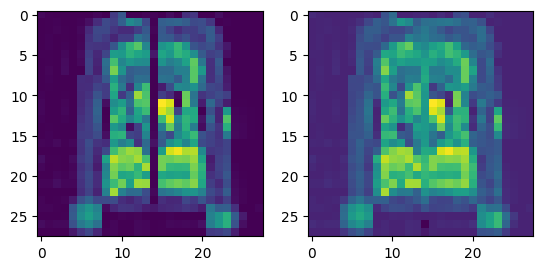

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

## Task 4: Utilizing various enhancing techniques try to boost the performance of the model including:

**Batch Normalization layers**

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

      output = NN(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)


    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.025450 	Training Loss: 0.042010
Model saved - Validation loss decreased from inf to 0.025450
Epoch: 2 	Test Loss: 0.022228 	Training Loss: 0.026273
Model saved - Validation loss decreased from 0.025450 to 0.022228
Epoch: 3 	Test Loss: 0.020437 	Training Loss: 0.023620
Model saved - Validation loss decreased from 0.022228 to 0.020437
Epoch: 4 	Test Loss: 0.019379 	Training Loss: 0.022180
Model saved - Validation loss decreased from 0.020437 to 0.019379
Epoch: 5 	Test Loss: 0.018597 	Training Loss: 0.021010
Model saved - Validation loss decreased from 0.019379 to 0.018597
Epoch: 6 	Test Loss: 0.017967 	Training Loss: 0.020275
Model saved - Validation loss decreased from 0.018597 to 0.017967
Epoch: 7 	Test Loss: 0.017564 	Training Loss: 0.019580
Model saved - Validation loss decreased from 0.017967 to 0.017564
Epoch: 8 	Test Loss: 0.017014 	Training Loss: 0.019190
Model saved - Validation loss decreased from 0.017564 to 0.017014
Epoch: 9 	Test Loss: 0.016660 	Traini

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


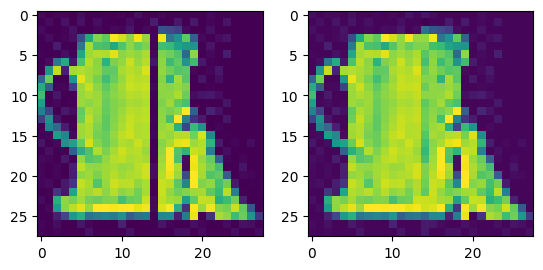

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

**Dropout Layer(Dropout rate = 0.1)**

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, dropout_prob=0.1):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.dropout = torch.nn.Dropout(dropout_prob) # dropout layer
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.dropout1 = torch.nn.Dropout(dropout_prob) # dropout layer
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.dropout1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

      output = NN(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)


    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    print('Epoch: {} \tTest Loss: {:.6f} \ttraining Loss: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.033938 	training Loss: 0.060089
Model saved - Validation loss decreased from inf to 0.033938
Epoch: 2 	Test Loss: 0.028554 	training Loss: 0.036444
Model saved - Validation loss decreased from 0.033938 to 0.028554
Epoch: 3 	Test Loss: 0.026350 	training Loss: 0.032591
Model saved - Validation loss decreased from 0.028554 to 0.026350
Epoch: 4 	Test Loss: 0.025039 	training Loss: 0.030563
Model saved - Validation loss decreased from 0.026350 to 0.025039
Epoch: 5 	Test Loss: 0.024090 	training Loss: 0.029229
Model saved - Validation loss decreased from 0.025039 to 0.024090
Epoch: 6 	Test Loss: 0.023276 	training Loss: 0.028245
Model saved - Validation loss decreased from 0.024090 to 0.023276
Epoch: 7 	Test Loss: 0.022812 	training Loss: 0.027409
Model saved - Validation loss decreased from 0.023276 to 0.022812
Epoch: 8 	Test Loss: 0.022402 	training Loss: 0.026823
Model saved - Validation loss decreased from 0.022812 to 0.022402
Epoch: 9 	Test Loss: 0.021626 	traini

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


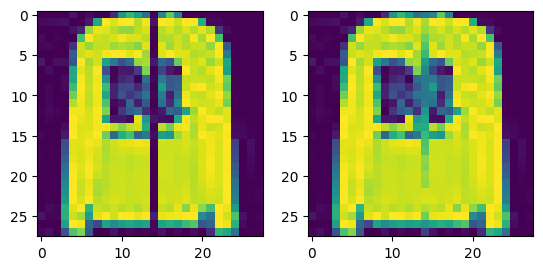

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

**Dropout Layer(Dropout rate = 0.2)**

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, dropout_prob=0.2):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.dropout = torch.nn.Dropout(dropout_prob) # dropout layer
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.dropout1 = torch.nn.Dropout(dropout_prob) # dropout layer
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.dropout1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

      output = NN(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)


    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    print('Epoch: {} \tTest Loss: {:.6f} \ttraining Loss: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.037111 	training Loss: 0.068083
Model saved - Validation loss decreased from inf to 0.037111
Epoch: 2 	Test Loss: 0.030841 	training Loss: 0.042678
Model saved - Validation loss decreased from 0.037111 to 0.030841
Epoch: 3 	Test Loss: 0.028853 	training Loss: 0.038089
Model saved - Validation loss decreased from 0.030841 to 0.028853
Epoch: 4 	Test Loss: 0.027117 	training Loss: 0.035792
Model saved - Validation loss decreased from 0.028853 to 0.027117
Epoch: 5 	Test Loss: 0.026183 	training Loss: 0.034265
Model saved - Validation loss decreased from 0.027117 to 0.026183
Epoch: 6 	Test Loss: 0.025340 	training Loss: 0.033066
Model saved - Validation loss decreased from 0.026183 to 0.025340
Epoch: 7 	Test Loss: 0.024844 	training Loss: 0.032222
Model saved - Validation loss decreased from 0.025340 to 0.024844
Epoch: 8 	Test Loss: 0.024298 	training Loss: 0.031364
Model saved - Validation loss decreased from 0.024844 to 0.024298
Epoch: 9 	Test Loss: 0.023676 	traini

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


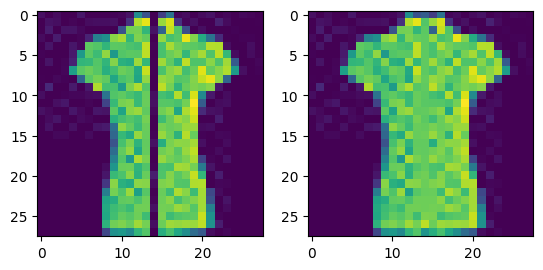

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

**Dropout Layer(Dropout rate = 0.5)**

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.dropout = torch.nn.Dropout(dropout_prob) # dropout layer
        self.leaky_relu = torch.nn.LeakyReLU()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.dropout1 = torch.nn.Dropout(dropout_prob) # dropout layer
        self.leaky_relu1 = torch.nn.LeakyReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.dropout(x)
        x = self.leaky_relu(x)
        x = self.hidden1(x)
        x = self.dropout1(x)
        x = self.leaky_relu1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

      output = NN(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)


    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    print('Epoch: {} \tTest Loss: {:.6f} \ttraining Loss: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.048098 	training Loss: 0.086578
Model saved - Validation loss decreased from inf to 0.048098
Epoch: 2 	Test Loss: 0.040408 	training Loss: 0.059212
Model saved - Validation loss decreased from 0.048098 to 0.040408
Epoch: 3 	Test Loss: 0.036407 	training Loss: 0.053255
Model saved - Validation loss decreased from 0.040408 to 0.036407
Epoch: 4 	Test Loss: 0.034831 	training Loss: 0.050433
Model saved - Validation loss decreased from 0.036407 to 0.034831
Epoch: 5 	Test Loss: 0.032963 	training Loss: 0.048106
Model saved - Validation loss decreased from 0.034831 to 0.032963
Epoch: 6 	Test Loss: 0.032114 	training Loss: 0.046594
Model saved - Validation loss decreased from 0.032963 to 0.032114
Epoch: 7 	Test Loss: 0.031983 	training Loss: 0.045232
Model saved - Validation loss decreased from 0.032114 to 0.031983
Epoch: 8 	Test Loss: 0.030659 	training Loss: 0.044159
Model saved - Validation loss decreased from 0.031983 to 0.030659
Epoch: 9 	Test Loss: 0.030372 	traini

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


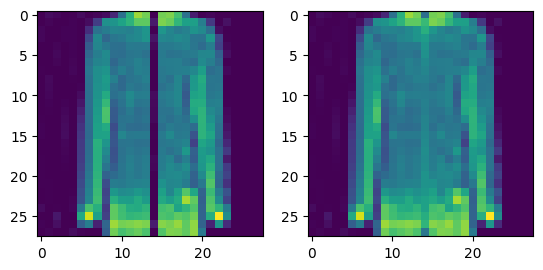

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

**activation functions**

So far we observed results using Leaky ReLU as activation function<br>
now we use sigmoid, tanh(Hyperbolic Tangent), regular ReLU and softmax as activation function

Function of Leaky ReLU was:<BR>
$$ LeakyReLU(x)=max(0,x)+negative slope\times min(0,x) $$

Sigmoid<br>
$$ Sigmoid(x)=σ=\frac{1}{1+exp(-x)} $$

In [ ]:
#Neural Network Class with Sigmoid as activation function
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.sigmoid = torch.nn.Sigmoid() # Sigmoid as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.sigmoid1 = torch.nn.Sigmoid()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.hidden1(x)
        x = self.sigmoid1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

      output = NN(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)


    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    print('Epoch: {} \tTest Loss: {:.6f} \tTrain Loss: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.097537 	Train Loss: 0.112278
Model saved - Validation loss decreased from inf to 0.097537
Epoch: 2 	Test Loss: 0.067316 	Train Loss: 0.080271
Model saved - Validation loss decreased from 0.097537 to 0.067316
Epoch: 3 	Test Loss: 0.059246 	Train Loss: 0.064538
Model saved - Validation loss decreased from 0.067316 to 0.059246
Epoch: 4 	Test Loss: 0.052438 	Train Loss: 0.056151
Model saved - Validation loss decreased from 0.059246 to 0.052438
Epoch: 5 	Test Loss: 0.048672 	Train Loss: 0.050844
Model saved - Validation loss decreased from 0.052438 to 0.048672
Epoch: 6 	Test Loss: 0.045367 	Train Loss: 0.047256
Model saved - Validation loss decreased from 0.048672 to 0.045367
Epoch: 7 	Test Loss: 0.042400 	Train Loss: 0.044147
Model saved - Validation loss decreased from 0.045367 to 0.042400
Epoch: 8 	Test Loss: 0.039514 	Train Loss: 0.041254
Model saved - Validation loss decreased from 0.042400 to 0.039514
Epoch: 9 	Test Loss: 0.037048 	Train Loss: 0.038509
Model sav

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


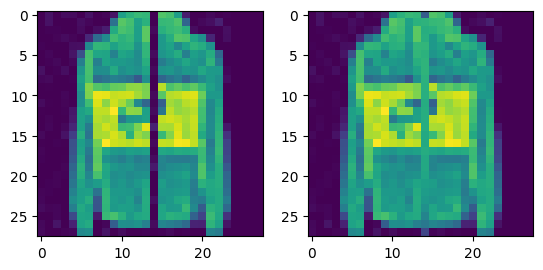

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

TanH(Hyperbolic Tangent)<br>
$$ Tanh(x)=tanh(x)=\frac{exp(x)−exp(−x)}{exp(x)+exp(−x)} $$

In [ ]:
#Neural Network Class with Tanh as activation function
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.tanh = torch.nn.Tanh() # Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.tanh1 = torch.nn.Tanh()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

      output = NN(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)


    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    print('Epoch: {} \tTest Loss: {:.6f} \tTrain Loss: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.030134 	Train Loss: 0.047899
Model saved - Validation loss decreased from inf to 0.030134
Epoch: 2 	Test Loss: 0.025864 	Train Loss: 0.027902
Model saved - Validation loss decreased from 0.030134 to 0.025864
Epoch: 3 	Test Loss: 0.023669 	Train Loss: 0.024860
Model saved - Validation loss decreased from 0.025864 to 0.023669
Epoch: 4 	Test Loss: 0.022324 	Train Loss: 0.023108
Model saved - Validation loss decreased from 0.023669 to 0.022324
Epoch: 5 	Test Loss: 0.021471 	Train Loss: 0.021907
Model saved - Validation loss decreased from 0.022324 to 0.021471
Epoch: 6 	Test Loss: 0.020584 	Train Loss: 0.020990
Model saved - Validation loss decreased from 0.021471 to 0.020584
Epoch: 7 	Test Loss: 0.019873 	Train Loss: 0.020253
Model saved - Validation loss decreased from 0.020584 to 0.019873
Epoch: 8 	Test Loss: 0.019380 	Train Loss: 0.019648
Model saved - Validation loss decreased from 0.019873 to 0.019380
Epoch: 9 	Test Loss: 0.018889 	Train Loss: 0.019148
Model sav

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


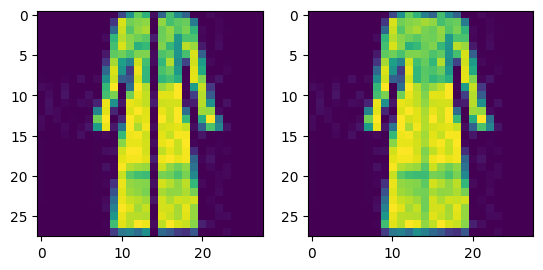

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

Regular ReLU<br>
$$ ReLU(x)=max(0,x) $$

In [ ]:
#Neural Network Class with Regular ReLU as activation function
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.relu = torch.nn.ReLU() # Regular ReLU as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.relu1 = torch.nn.ReLU()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.hidden1(x)
        x = self.relu1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

      output = NN(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)


    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    print('Epoch: {} \tTest Loss: {:.6f} \tTrain Loss: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss
        ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.032985 	Train Loss: 0.056806
Model saved - Validation loss decreased from inf to 0.032985
Epoch: 2 	Test Loss: 0.027668 	Train Loss: 0.030159
Model saved - Validation loss decreased from 0.032985 to 0.027668
Epoch: 3 	Test Loss: 0.025141 	Train Loss: 0.026584
Model saved - Validation loss decreased from 0.027668 to 0.025141
Epoch: 4 	Test Loss: 0.023518 	Train Loss: 0.024509
Model saved - Validation loss decreased from 0.025141 to 0.023518
Epoch: 5 	Test Loss: 0.022292 	Train Loss: 0.023074
Model saved - Validation loss decreased from 0.023518 to 0.022292
Epoch: 6 	Test Loss: 0.021376 	Train Loss: 0.021984
Model saved - Validation loss decreased from 0.022292 to 0.021376
Epoch: 7 	Test Loss: 0.020526 	Train Loss: 0.021063
Model saved - Validation loss decreased from 0.021376 to 0.020526
Epoch: 8 	Test Loss: 0.019939 	Train Loss: 0.020304
Model saved - Validation loss decreased from 0.020526 to 0.019939
Epoch: 9 	Test Loss: 0.019258 	Train Loss: 0.019651
Model sav

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


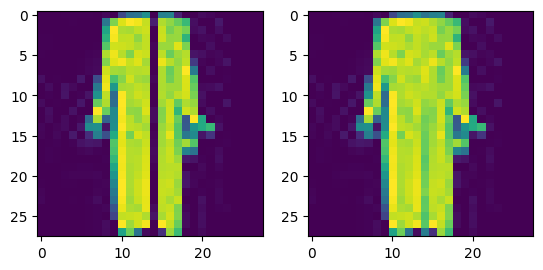

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

Tanh is best activation function for this dataset<br>
batch normalization improved model<br>
adding dropout layers did not improve model<br>
so we use Tanh as activation function and use batch normalization without dropout


**Learning rate scheduling**

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh()
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh()
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9) # SGD as optimizer
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.018128 	Training Loss: 0.019331 	Learning Rate: 0.000100
Model saved - Validation loss decreased from inf to 0.018128
Epoch: 2 	Test Loss: 0.018044 	Training Loss: 0.019412 	Learning Rate: 0.000100
Model saved - Validation loss decreased from 0.018128 to 0.018044
Epoch: 3 	Test Loss: 0.018128 	Training Loss: 0.019265 	Learning Rate: 0.000100
Epoch: 4 	Test Loss: 0.018103 	Training Loss: 0.019271 	Learning Rate: 0.000100
Epoch: 5 	Test Loss: 0.018072 	Training Loss: 0.019307 	Learning Rate: 0.000010
Epoch: 6 	Test Loss: 0.018117 	Training Loss: 0.019233 	Learning Rate: 0.000010
Epoch: 7 	Test Loss: 0.018033 	Training Loss: 0.019264 	Learning Rate: 0.000010
Model saved - Validation loss decreased from 0.018044 to 0.018033
Epoch: 8 	Test Loss: 0.018071 	Training Loss: 0.019279 	Learning Rate: 0.000010
Epoch: 9 	Test Loss: 0.018084 	Training Loss: 0.019296 	Learning Rate: 0.000010
Epoch: 10 	Test Loss: 0.018038 	Training Loss: 0.019303 	Learning Rate: 0.000001


In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


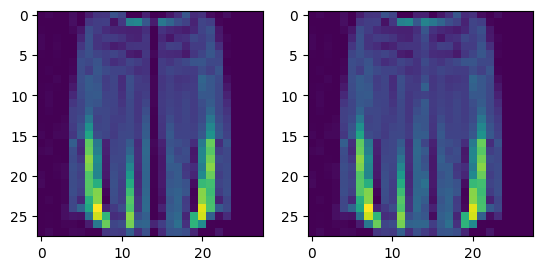

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

SO as observed our model was improved after implementing Learning rate scheduling


**L1, L2 Regularization**

L1 Regularization

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh() #Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh() #Tanh as activation function
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9)
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        #adding L1 regularization
        l1_lambda = 0.001
        l1_norm = sum(p.abs().sum()
                  for p in NN.parameters())

        loss = loss + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.038878 	Training Loss: 1.226714 	Learning Rate: 0.010000
Model saved - Validation loss decreased from inf to 0.038878
Epoch: 2 	Test Loss: 0.033953 	Training Loss: 0.369748 	Learning Rate: 0.010000
Model saved - Validation loss decreased from 0.038878 to 0.033953
Epoch: 3 	Test Loss: 0.028743 	Training Loss: 0.335669 	Learning Rate: 0.010000
Model saved - Validation loss decreased from 0.033953 to 0.028743
Epoch: 4 	Test Loss: 0.027465 	Training Loss: 0.310191 	Learning Rate: 0.010000
Model saved - Validation loss decreased from 0.028743 to 0.027465
Epoch: 5 	Test Loss: 0.036743 	Training Loss: 0.285528 	Learning Rate: 0.001000
Epoch: 6 	Test Loss: 0.021896 	Training Loss: 0.256757 	Learning Rate: 0.001000
Model saved - Validation loss decreased from 0.027465 to 0.021896
Epoch: 7 	Test Loss: 0.025271 	Training Loss: 0.253207 	Learning Rate: 0.001000
Epoch: 8 	Test Loss: 0.020135 	Training Loss: 0.250906 	Learning Rate: 0.001000
Model saved - Validation loss decre

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


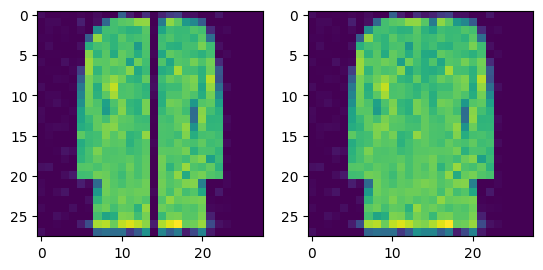

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

L2 Regularization

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh() #Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh() #Tanh as activation function
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9, weight_decay=1e-5)
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        # L2
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in NN.parameters())

        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.024336 	Training Loss: 0.430631 	Learning Rate: 0.000100
Model saved - Validation loss decreased from inf to 0.024336
Epoch: 2 	Test Loss: 0.020725 	Training Loss: 0.305982 	Learning Rate: 0.000100
Model saved - Validation loss decreased from 0.024336 to 0.020725
Epoch: 3 	Test Loss: 0.018422 	Training Loss: 0.230919 	Learning Rate: 0.000100
Model saved - Validation loss decreased from 0.020725 to 0.018422
Epoch: 4 	Test Loss: 0.017186 	Training Loss: 0.176226 	Learning Rate: 0.000100
Model saved - Validation loss decreased from 0.018422 to 0.017186
Epoch: 5 	Test Loss: 0.017034 	Training Loss: 0.136376 	Learning Rate: 0.000010
Model saved - Validation loss decreased from 0.017186 to 0.017034
Epoch: 6 	Test Loss: 0.016630 	Training Loss: 0.107319 	Learning Rate: 0.000010
Model saved - Validation loss decreased from 0.017034 to 0.016630
Epoch: 7 	Test Loss: 0.016432 	Training Loss: 0.086227 	Learning Rate: 0.000010
Model saved - Validation loss decreased from 0.01

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


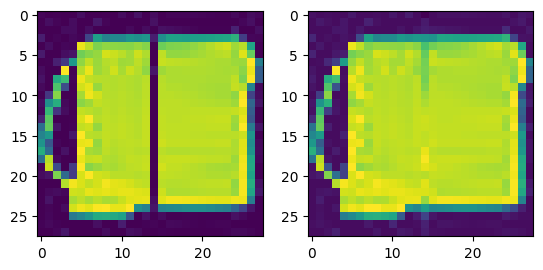

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

L1 regularization not recommended for this dataset but L2 regularization improved model

**Different Weight initialization**

In [ ]:
# Define a custom weight initialization function
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data)
        m.bias.data.fill_(0.01)

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh() #Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh() #Tanh as activation function
        self.output = torch.nn.Linear(64, 28)

        # Apply custom weight initialization
        self.apply(init_weights)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9, weight_decay=1e-5)
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity


for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        # L2
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in NN.parameters())

        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss

Epoch: 1 	Test Loss: 0.031667 	Training Loss: 0.795542 	Learning Rate: 0.000001
Model saved - Validation loss decreased from inf to 0.031667
Epoch: 2 	Test Loss: 0.026198 	Training Loss: 0.569911 	Learning Rate: 0.000001
Model saved - Validation loss decreased from 0.031667 to 0.026198
Epoch: 3 	Test Loss: 0.023169 	Training Loss: 0.425711 	Learning Rate: 0.000001
Model saved - Validation loss decreased from 0.026198 to 0.023169
Epoch: 4 	Test Loss: 0.021150 	Training Loss: 0.320392 	Learning Rate: 0.000001
Model saved - Validation loss decreased from 0.023169 to 0.021150
Epoch: 5 	Test Loss: 0.019966 	Training Loss: 0.242962 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.021150 to 0.019966
Epoch: 6 	Test Loss: 0.018749 	Training Loss: 0.185757 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.019966 to 0.018749
Epoch: 7 	Test Loss: 0.018310 	Training Loss: 0.143744 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.01

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


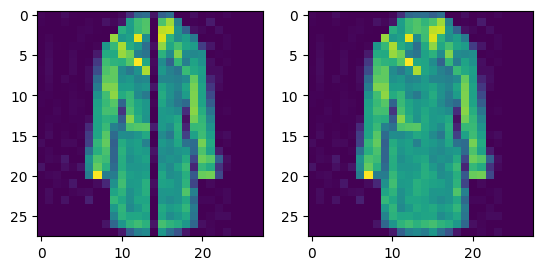

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

didn't improve model

**Early stopping**

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh() #Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh() #Tanh as activation function
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.SGD(NN.parameters(), lr = 0.01, momentum = 0.9, weight_decay=1e-5)
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity
patience = 3 # set the number of epochs to wait before stopping

counter = 0 # initialize the counter variable to zero

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        # L2
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in NN.parameters())

        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss
        counter = 0 # reset the counter if validation loss decreases
    else:
        counter += 1 # increment the counter if validation loss does not decrease
    # stop training if validation loss has not decreased for a certain number of epochs
    if counter >= patience:
        print('Early stopping - validation loss has not decreased for {} epochs'.format(patience))
        break

Epoch: 1 	Test Loss: 0.023953 	Training Loss: 0.431769 	Learning Rate: 0.000000
Model saved - Validation loss decreased from inf to 0.023953
Epoch: 2 	Test Loss: 0.020104 	Training Loss: 0.305901 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.023953 to 0.020104
Epoch: 3 	Test Loss: 0.018477 	Training Loss: 0.230933 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.020104 to 0.018477
Epoch: 4 	Test Loss: 0.017057 	Training Loss: 0.176361 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.018477 to 0.017057
Epoch: 5 	Test Loss: 0.016819 	Training Loss: 0.136397 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.017057 to 0.016819
Epoch: 6 	Test Loss: 0.016587 	Training Loss: 0.107338 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.016819 to 0.016587
Epoch: 7 	Test Loss: 0.017002 	Training Loss: 0.086364 	Learning Rate: 0.000000
Epoch: 8 	Test Loss: 0.016749 	Training Loss: 0.0

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


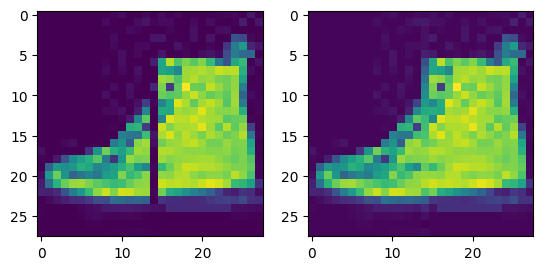

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

As observed we earn best possible accuracy

**different optimizers**

At this step we check performance on below optimizers(so far we implement on SGD optimizer)<br>
RMSprop, Adam, Adagrad, Adadelta

RMSprop

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh() #Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh() #Tanh as activation function
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.RMSprop(NN.parameters(), lr = 0.01, momentum = 0, weight_decay=1e-5)
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity
patience = 3 # set the number of epochs to wait before stopping

counter = 0 # initialize the counter variable to zero

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        # L2
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in NN.parameters())

        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss
        counter = 0 # reset the counter if validation loss decreases
    else:
        counter += 1 # increment the counter if validation loss does not decrease
    # stop training if validation loss has not decreased for a certain number of epochs
    if counter >= patience:
        print('Early stopping - validation loss has not decreased for {} epochs'.format(patience))
        break

Epoch: 1 	Test Loss: 0.077151 	Training Loss: 0.127844 	Learning Rate: 0.000000
Model saved - Validation loss decreased from inf to 0.077151
Epoch: 2 	Test Loss: 0.061894 	Training Loss: 0.066322 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.077151 to 0.061894
Epoch: 3 	Test Loss: 0.071268 	Training Loss: 0.066724 	Learning Rate: 0.000000
Epoch: 4 	Test Loss: 0.067080 	Training Loss: 0.066007 	Learning Rate: 0.000000
Epoch: 5 	Test Loss: 0.043703 	Training Loss: 0.066442 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.061894 to 0.043703
Epoch: 6 	Test Loss: 0.045167 	Training Loss: 0.066386 	Learning Rate: 0.000000
Epoch: 7 	Test Loss: 0.052087 	Training Loss: 0.066913 	Learning Rate: 0.000000
Epoch: 8 	Test Loss: 0.061526 	Training Loss: 0.066121 	Learning Rate: 0.000000
Early stopping - validation loss has not decreased for 3 epochs


In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


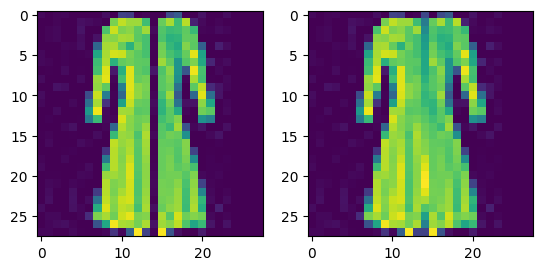

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

Adam

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh() #Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh() #Tanh as activation function
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.Adam(NN.parameters(), lr = 0.001, weight_decay=1e-5)
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity
patience = 3 # set the number of epochs to wait before stopping

counter = 0 # initialize the counter variable to zero

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        # L2
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in NN.parameters())

        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss
        counter = 0 # reset the counter if validation loss decreases
    else:
        counter += 1 # increment the counter if validation loss does not decrease
    # stop training if validation loss has not decreased for a certain number of epochs
    if counter >= patience:
        print('Early stopping - validation loss has not decreased for {} epochs'.format(patience))
        break

Epoch: 1 	Test Loss: 0.023024 	Training Loss: 0.227258 	Learning Rate: 0.000000
Model saved - Validation loss decreased from inf to 0.023024
Epoch: 2 	Test Loss: 0.025412 	Training Loss: 0.056236 	Learning Rate: 0.000000
Epoch: 3 	Test Loss: 0.025306 	Training Loss: 0.038738 	Learning Rate: 0.000000
Epoch: 4 	Test Loss: 0.025330 	Training Loss: 0.036707 	Learning Rate: 0.000000
Early stopping - validation loss has not decreased for 3 epochs


In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


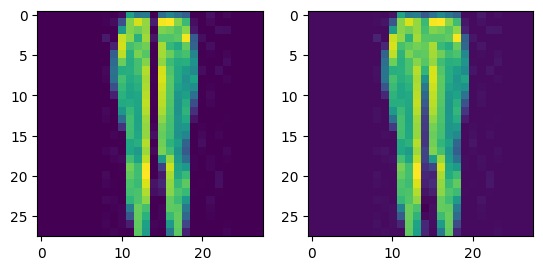

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

Adagrad

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh() #Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh() #Tanh as activation function
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.Adagrad(NN.parameters(), lr_decay=0, lr = 0.01, weight_decay=1e-5)
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity
patience = 3 # set the number of epochs to wait before stopping

counter = 0 # initialize the counter variable to zero

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        # L2
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in NN.parameters())

        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss
        counter = 0 # reset the counter if validation loss decreases
    else:
        counter += 1 # increment the counter if validation loss does not decrease
    # stop training if validation loss has not decreased for a certain number of epochs
    if counter >= patience:
        print('Early stopping - validation loss has not decreased for {} epochs'.format(patience))
        break

Epoch: 1 	Test Loss: 0.031396 	Training Loss: 0.224491 	Learning Rate: 0.000000
Model saved - Validation loss decreased from inf to 0.031396
Epoch: 2 	Test Loss: 0.025451 	Training Loss: 0.104889 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.031396 to 0.025451
Epoch: 3 	Test Loss: 0.025521 	Training Loss: 0.069762 	Learning Rate: 0.000000
Epoch: 4 	Test Loss: 0.025334 	Training Loss: 0.053219 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.025451 to 0.025334
Epoch: 5 	Test Loss: 0.024745 	Training Loss: 0.044520 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.025334 to 0.024745
Epoch: 6 	Test Loss: 0.024506 	Training Loss: 0.040084 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.024745 to 0.024506
Epoch: 7 	Test Loss: 0.020656 	Training Loss: 0.037439 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.024506 to 0.020656
Epoch: 8 	Test Loss: 0.020068 	Training Loss: 0.0

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


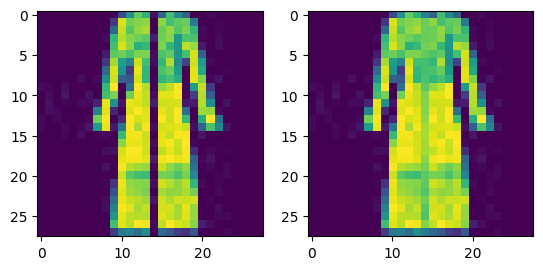

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()

Adadelta

In [ ]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = torch.nn.Linear(28 * 28, 256)
        self.batch_norm = torch.nn.BatchNorm1d(256) #batch normalization layer
        self.tanh = torch.nn.Tanh() #Tanh as activation function
        self.hidden1 = torch.nn.Linear(256, 64)
        self.batch_norm1 = torch.nn.BatchNorm1d(64) #batch normalization layer
        self.tanh1 = torch.nn.Tanh() #Tanh as activation function
        self.output = torch.nn.Linear(64, 28)

    def forward(self, x):
        x = x.to(torch.float32)
        x = x.view(-1, 28*28)
        x = self.hidden(x)
        x = self.batch_norm(x)
        x = self.tanh(x)
        x = self.hidden1(x)
        x = self.batch_norm1(x)
        x = self.tanh1(x)
        x = self.output(x)

        return x

In [ ]:
NN = NeuralNetwork()
NN.train()
optimizer = optim.Adadelta(NN.parameters(), lr = 0.1, weight_decay=1e-5)
criterion = nn.MSELoss() #Mean Square Error as loss function
n_epochs = 10

In [ ]:
test_loss_min = np.Inf  # set initial "min" to infinity
patience = 3 # set the number of epochs to wait before stopping

counter = 0 # initialize the counter variable to zero

for epoch in range(n_epochs):
    train_loss = 0.0
    test_loss = 0.0

    NN.train()
    for data, label in dataloader_train:
        optimizer.zero_grad()
        output = NN(data)
        loss = criterion(output, label)
        # L2
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                  for p in NN.parameters())

        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    NN.eval()
    for data, label in dataloader_test:

        output = NN(data)
        loss = criterion(output, label)
        test_loss += loss.item()*data.size(0)

    # calculate average loss over an epoch
    train_loss = train_loss/len(dataloader_train.dataset)
    test_loss = test_loss/len(dataloader_test.dataset)

    scheduler.step()  # adjust the learning rate

    print('Epoch: {} \tTest Loss: {:.6f} \tTraining Loss: {:.6f} \tLearning Rate: {:.6f}'.format(
        epoch+1,
        test_loss,
        train_loss,
        scheduler.get_last_lr()[0]
    ))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Model saved - Validation loss decreased from {:.6f} to {:.6f}'.format(
        test_loss_min,
        test_loss))
        torch.save(NN.state_dict(), 'model.pt')
        test_loss_min = test_loss
        counter = 0 # reset the counter if validation loss decreases
    else:
        counter += 1 # increment the counter if validation loss does not decrease
    # stop training if validation loss has not decreased for a certain number of epochs
    if counter >= patience:
        print('Early stopping - validation loss has not decreased for {} epochs'.format(patience))
        break

Epoch: 1 	Test Loss: 0.025355 	Training Loss: 0.451249 	Learning Rate: 0.000000
Model saved - Validation loss decreased from inf to 0.025355
Epoch: 2 	Test Loss: 0.021757 	Training Loss: 0.311005 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.025355 to 0.021757
Epoch: 3 	Test Loss: 0.019227 	Training Loss: 0.235841 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.021757 to 0.019227
Epoch: 4 	Test Loss: 0.019048 	Training Loss: 0.180822 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.019227 to 0.019048
Epoch: 5 	Test Loss: 0.017397 	Training Loss: 0.140409 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.019048 to 0.017397
Epoch: 6 	Test Loss: 0.016439 	Training Loss: 0.110661 	Learning Rate: 0.000000
Model saved - Validation loss decreased from 0.017397 to 0.016439
Epoch: 7 	Test Loss: 0.018509 	Training Loss: 0.089017 	Learning Rate: 0.000000
Epoch: 8 	Test Loss: 0.018074 	Training Loss: 0.0

In [ ]:
data, label = next(iter(dataloader_test))
NN.eval()
output = NN(data)
print(output.shape)

torch.Size([64, 28])


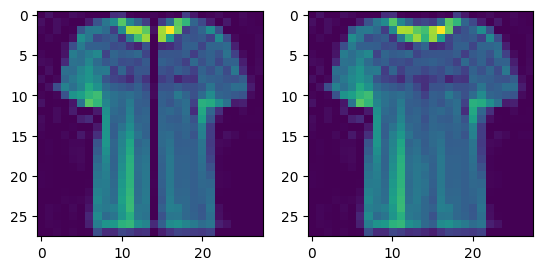

In [ ]:
# Reshape data and plot original image
data = data.reshape(64, 28, 28)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0, :, :].detach().numpy())

# Update data with output and plot updated image
data[0:, :, 14] = output[0, :]
ax2.imshow(data[0, :, :].detach().numpy())

plt.show()